In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls /content/drive/MyDrive/ColabNotebooks/DeepCovid-master/data/train

covid  non


# Roc Curve for all the models

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  w

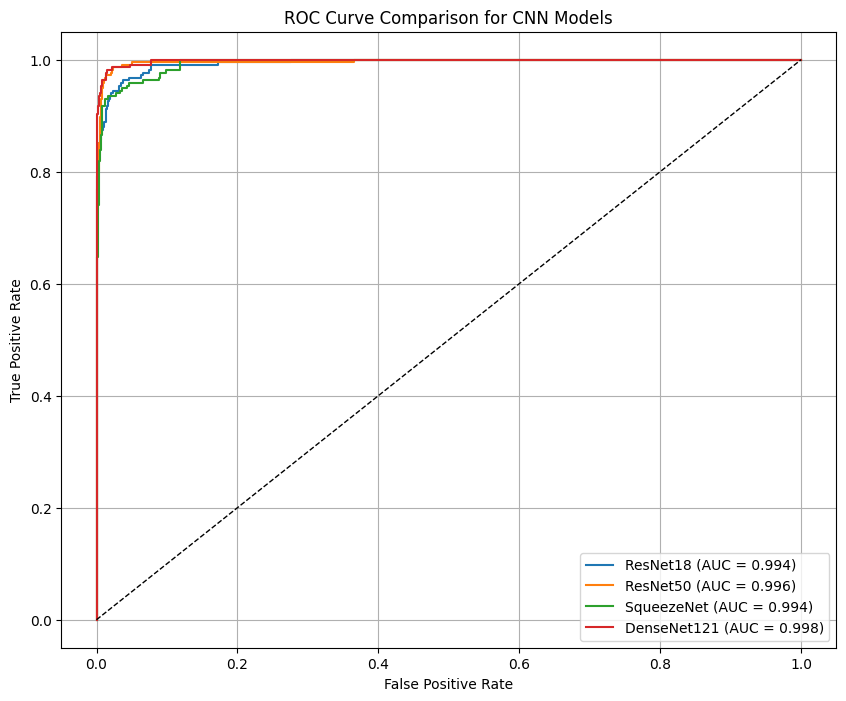

In [3]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import glob
import PIL.Image as Image

from torchvision.models.resnet import ResNet, BasicBlock
from torchvision.models.densenet import DenseNet
from torchvision.models.squeezenet import SqueezeNet

torch.serialization.add_safe_globals([ResNet, BasicBlock, DenseNet, SqueezeNet])


# --------------------------
# CONFIG
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 224
covid_path = '/content/drive/MyDrive/ColabNotebooks/DeepCovid-master/data/val/covid/'
non_path = '/content/drive/MyDrive/ColabNotebooks/DeepCovid-master/data/val/non/'

model_paths = {
    'ResNet18': '/content/drive/MyDrive/ColabNotebooks/DeepCovid-master/ResNet18/covid_resnet18_epoch50.pt',
    'ResNet50': '/content/drive/MyDrive/ColabNotebooks/DeepCovid-master/Resnet50/covid_resnet50_epoch100.pt',
    'SqueezeNet': '/content/drive/MyDrive/ColabNotebooks/DeepCovid-master/SqueezeNet/covid_squeezeNet_epoch50.pt',
    'DenseNet121': '/content/drive/MyDrive/ColabNotebooks/DeepCovid-master/DenseNet-121/covid_denseNet_epoch1.pt',
}

# --------------------------
# Image Loader
# --------------------------
transform = transforms.Compose([
    transforms.Resize(imsize),
    transforms.CenterCrop(imsize),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

def load_image_tensor(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    return image.to(device)

# --------------------------
# Run Inference & Collect Scores
# --------------------------
def get_probs(model, image_paths):
    probs = []
    model.eval()
    softmax = torch.nn.Softmax(dim=1)
    for path in image_paths:
        img = load_image_tensor(path)
        with torch.no_grad():
            output = model(img)
            prob = softmax(output)[0, 0].item()  # COVID class = 1st class (index 0)
            probs.append(prob)
    return probs

# --------------------------
# Load and Run Models
# --------------------------
def load_and_eval(model_name, path):
    # Load appropriate model
    if model_name == 'ResNet18':
        model = models.resnet18(pretrained=False)
        model.fc = torch.nn.Linear(model.fc.in_features, 2)
    elif model_name == 'ResNet50':
        model = models.resnet50(pretrained=False)
        model.fc = torch.nn.Linear(model.fc.in_features, 2)
    elif model_name == 'SqueezeNet':
        model = models.squeezenet1_1(pretrained=False)
        model.classifier[1] = torch.nn.Conv2d(512, 2, kernel_size=(1,1))
    elif model_name == 'DenseNet121':
        model = models.densenet121(pretrained=False)
        model.classifier = torch.nn.Linear(model.classifier.in_features, 2)
    else:
        raise ValueError("Unknown model: " + model_name)

    # Load weights
    model = torch.load(path, map_location=device, weights_only=False)
    model.to(device)

    # Get probabilities
    covid_probs = get_probs(model, covid_imgs)
    non_probs = get_probs(model, non_imgs)
    return covid_probs, non_probs

# --------------------------
# Get Test Image Paths
# --------------------------
image_extensions = ('.jpg', '.png', '.jpeg')
covid_imgs = [f for f in glob.glob(covid_path + '**/*', recursive=True) if f.lower().endswith(image_extensions)]
non_imgs = [f for f in glob.glob(non_path + '**/*', recursive=True) if f.lower().endswith(image_extensions)]

# --------------------------
# Run ROC for All Models
# --------------------------
plt.figure(figsize=(10, 8))

for model_name, model_path in model_paths.items():
    covid_probs, non_probs = load_and_eval(model_name, model_path)

    y_true = [1]*len(covid_probs) + [0]*len(non_probs)
    y_score = covid_probs + non_probs

    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)

    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})')

# --------------------------
# Final ROC Plot Settings
# --------------------------
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison for CNN Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('/content/drive/MyDrive/ColabNotebooks/DeepCovid-master/roc_comparison_all_models.png', bbox_inches='tight')
plt.show()
